In [1]:
# -*- encoding: utf-8 -*-
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# data preparing

In [2]:
# data preparing
BCHAIN = pd.read_csv('BCHAIN-MKPRU.csv', header=0)
GOLD = pd.read_csv('LBMA-GOLD.csv', header=0)
# to datetime
BCHAIN.Date = pd.to_datetime(BCHAIN.Date)
GOLD.Date = pd.to_datetime(GOLD.Date)
# merge
df = pd.merge(BCHAIN, GOLD, how='inner',on='Date')
df.columns = ['Date', 'BCHAIN', 'GOLD']
df = df.set_index('Date').rename_axis('Asset', axis=1)
# before fill
df.GOLD = df.GOLD.fillna(method="ffill")
df = df.dropna()
df['CASH'] = 1.0
df.head()
# df.to_csv('BCHAIN-GOLD_inner.csv')

# 1) Calculate periodic returns of the stocks in the portfolio
>https://www.interviewqs.com/blog/value-at-risk#:~:text=Calculating%20Value%20at%20Risk%20%28VaR%29%20of%20a%20stock,firm%20or%20portfolio%20over%20a%20specified%20time%20frame.

In [3]:
# Set the investment weights (I arbitrarily picked for example)
weights = np.array([.2, .8, .0])

# Set an initial investment level
# initial_investment = 1000000
initial_investment = 1000


#From the closing prices, calculate periodic returns
returns = df.pct_change()

returns.tail()

Asset,BCHAIN,GOLD,CASH
Date,,,
2021-09-06,0.049465,-0.001152,0.0
2021-09-07,0.017546,-0.010677,0.0
2021-09-08,-0.111399,-0.008962,0.0
2021-09-09,-0.015612,0.001260,0.0
2021-09-10,0.006300,0.003551,0.0


# 2) Create a covariance matrix based on the returns

In [4]:
# Generate Var-Cov matrix
cov_matrix = returns.cov()
cov_matrix

Asset,BCHAIN,GOLD,CASH
Asset,,,
BCHAIN,0.002345,0.000019,0.0
GOLD,0.000019,0.000075,0.0
CASH,0.000000,0.000000,0.0


# 3) Calculate the portfolio mean and standard deviation

In [5]:
# Calculate mean returns for each stock
avg_rets = returns.mean()
 
# Calculate mean returns for portfolio overall, 
# using dot product to 
# normalize individual means against investment weights
 # https://en.wikipedia.org/wiki/Dot_product#:~:targetText=In%20mathematics%2C%20the%20dot%20product,and%20returns%20a%20single%20number.
port_mean = avg_rets.dot(weights)
 
# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
 
# Calculate mean of investment
mean_investment = (1+port_mean) * initial_investment
             
# Calculate standard deviation of investmnet
stdev_investment = initial_investment * port_stdev

In [6]:
print(port_mean)
print(port_stdev)
print(weights)
print(avg_rets)
print(returns.var())

0.0011455577288711101
0.012156274330111698
[0.2 0.8 0. ]
Asset
BCHAIN    0.004617
GOLD      0.000278
CASH      0.000000
dtype: float64
Asset
BCHAIN    0.002345
GOLD      0.000075
CASH      0.000000
dtype: float64


# 4) Calculate the inverse of the normal cumulative distribution (PPF) with a specified confidence interval, standard deviation, and mean

In [7]:
# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our portfolio
# as calculated above
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
from scipy.stats import norm
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

# from scipy.stats import t
# cutoff1 = t.ppf(conf_level1, mean_investment, stdev_investment)

# 5) Estimate the value at risk (VaR) for the portfolio by subtracting the initial investment from the calculation in step 4

In [8]:
#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
var_1d1
#output
#22347.7792230231

18.849734193230233

1 day VaR @ 95% confidence: 18.85
2 day VaR @ 95% confidence: 26.66
3 day VaR @ 95% confidence: 32.65
4 day VaR @ 95% confidence: 37.7
5 day VaR @ 95% confidence: 42.15
6 day VaR @ 95% confidence: 46.17
7 day VaR @ 95% confidence: 49.87
8 day VaR @ 95% confidence: 53.32
9 day VaR @ 95% confidence: 56.55
10 day VaR @ 95% confidence: 59.61
11 day VaR @ 95% confidence: 62.52
12 day VaR @ 95% confidence: 65.3
13 day VaR @ 95% confidence: 67.96
14 day VaR @ 95% confidence: 70.53
15 day VaR @ 95% confidence: 73.0


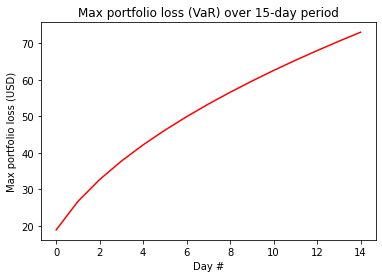

In [9]:
# Calculate n Day VaR
var_array = []
num_days = int(15)
for x in range(1, num_days+1):    
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")

(Extra) Checking distributions of our equities against normal distribution
As mentioned in the calculation section, we are assuming that the returns of the equities in our portfolio are normally distributed when calculating VaR. Of course, we can't predict that moving forward, but we can at least check how the historical returns have been distributed to help us assess whether VaR is suitable to use for our portfolio.

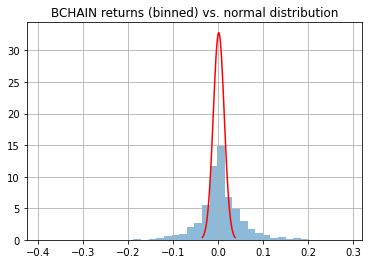

In [10]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy
# Repeat for each equity in portfolio
returns['BCHAIN'].hist(bins=40, density=1, histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("BCHAIN returns (binned) vs. normal distribution")
plt.show()

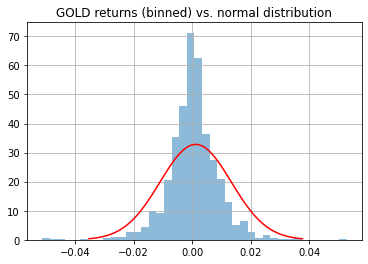

In [11]:
returns['GOLD'].hist(bins=40, density=1, histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("GOLD returns (binned) vs. normal distribution")
plt.show()

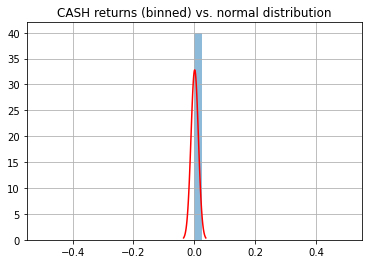

In [12]:
returns['CASH'].hist(bins=40, density=1, histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("CASH returns (binned) vs. normal distribution")
plt.show()